In [1]:
library(pigur)
library(Seurat)

Le chargement a nécessité le package : SeuratObject

Le chargement a nécessité le package : sp


Attachement du package : ‘SeuratObject’


L'objet suivant est masqué depuis ‘package:base’:

    intersect




## Load and subset data


In [2]:
seurat_object <- readRDS('../objects/seurat_object_integrated.rds')

In [4]:
table(seurat_object$NK_Subset,seurat_object$Stim,seurat_object$orig.ident)

, ,  = CURRENT_MIX1

             
                NS IFNa IL15  IL2   TH
  CD56_Bright   84  206   88   98    0
  CD56_Dim    3287 3357 4513 4044    0
  Other         34   12    9   18    0

, ,  = CURRENT_MIX2

             
                NS IFNa IL15  IL2   TH
  CD56_Bright   63  293   92   90    0
  CD56_Dim    4458 4514 5523 4431    0
  Other          8   12    3    5    0

, ,  = CURRENT_MIX3

             
                NS IFNa IL15  IL2   TH
  CD56_Bright   53  304   71  104    0
  CD56_Dim    3464 4127 5176 4492    0
  Other          4   10   15    7    0

, ,  = PREV_mix1

             
                NS IFNa IL15  IL2   TH
  CD56_Bright   93    0    0    0  597
  CD56_Dim    3255    0    0    0 6001
  Other          9    0    0    0   18

, ,  = PREV_mix2

             
                NS IFNa IL15  IL2   TH
  CD56_Bright  297    0    0    0  262
  CD56_Dim    6911    0    0    0 3380
  Other         27    0    0    0    6


In [5]:
ns_il15 <- seurat_object[,seurat_object$Stim %in% c('NS','IL15') &
                         seurat_object$orig.ident %in% c('CURRENT_MIX1','CURRENT_MIX2','CURRENT_MIX3') &
                         seurat_object$NK_Subset %in% c('CD56_Dim','CD56_Bright')]
ns_il15

An object of class Seurat 
36607 features across 26872 samples within 2 assays 
Active assay: RNA (36601 features, 5000 variable features)
 3 layers present: data, counts, scale.data
 1 other assay present: PREDICTED_MARKERS
 4 dimensional reductions calculated: pca, umap.unintegrated, integrated.harmony, umap.integrated.harmony

## Differential gene expression
here I just use Seurat's FindMarkers, but other type of differential expression can be used, as lons as it yields a log2FC and pvalues columns

In [6]:
deRes <- NULL
Idents(ns_il15) <- ns_il15$Stim

for(group in c('CD56_Dim','CD56_Bright'))
{
    deResults <- FindMarkers(ns_il15[,ns_il15$NK_Subset == group],
                ident.1 = 'IL15',
                ident.2 = 'NS',
                min.pct = 0.02,
                logfc.threshold = 0,
                min.cells.feature = 10,
                min.cells.group = 10, 
                test.use='wilcox',
                )
    #Set the gene column
    deResults$gene = rownames(deResults)
    rownames(deResults) <- NULL
    
    deResults$NK_Subset = group
    if(is.null(deRes))
    {
        deRes <- deResults
    } else {
        deRes <- rbind(deRes,deResults)
    }
}

In [7]:
head(deRes)

p_val avg_log2FC pct.1 pct.2 p_val_adj gene     NK_Subset
1 0     3.812484   0.827 0.087 0         CCND2    CD56_Dim 
2 0     3.587606   0.805 0.164 0         LGALS1   CD56_Dim 
3 0     3.007750   0.854 0.262 0         TUBA1B   CD56_Dim 
4 0     2.543084   0.846 0.285 0         HSP90AB1 CD56_Dim 
5 0     2.492279   0.838 0.278 0         ENO1     CD56_Dim 
6 0     2.555695   0.741 0.182 0         CALR     CD56_Dim

## Load Genesets
Load GMT genesets (From MSigDB) from a local folder

In [8]:
gs <- pigur::LoadGeneSetsGMTs("../genesets")

[1] "Loading c2.cp.v2023.1.Hs.symbols.gmt..."
[1] "Loaded 3090 genesets"
[1] "Loading h.all.v2023.1.Hs.symbols.gmt..."
[1] "Loaded 50 genesets"
[1] "Total number of genesets files loaded: 2"


## Create Ranked Gene List
Create Ranked gene lists from DGE results

In [9]:
#detach("package:pigur", unload=TRUE)
rankings <- pigur::CreateRanking(deRes,
                                 pvalColumn="p_val", 
                                 log2FCColumn="avg_log2FC",
                                 geneColumn="gene",
                                 twoSided=TRUE,
                                 groupByColumn="NK_Subset")

In [10]:
head(rankings$CD56_Dim)
head(rankings$CD56_Bright)

CCND2    LGALS1    TUBA1B  HSP90AB1      ENO1      CALR 
1143.7451 1076.2817  902.3250  762.9253  747.6837  766.7085

ACTB     CCND2      ENO1      GZMB  HSP90AB1    TUBA1B 
 86.38993 125.13478  87.73730  97.04130  70.94207  76.96254

## Run FGSEA
Run FGSEA on each geneset type (Hallmark and C2P) and each cell subsets (NK Dim and NK Bright)

In [11]:
fgseaRes <- pigur::RunFGSEAMultilevelBatch(genesetLists=gs,
                                           rankedGeneLists=rankings,
                                           removeGenePattern="RPS|RPL|MT-",
                                           sampleSize = 101,
                                           minSize = 15, 
                                           nproc = 8, nPermSimple=10000)
head(fgseaRes[order(fgseaRes$padj)],20)

[1] "Running CD56_Dim; on c2.cp.v2023.1.Hs.symbols"
  |======================================================================| 100%

[1] "Running CD56_Bright; on c2.cp.v2023.1.Hs.symbols"
  |======================================================================| 100%

[1] "Running CD56_Dim; on h.all.v2023.1.Hs.symbols"
  |======================================================================| 100%

[1] "Running CD56_Bright; on h.all.v2023.1.Hs.symbols"
  |======================================================================| 100%



pathway                                          pval         padj        
1  REACTOME_CELL_CYCLE_MITOTIC                      2.338443e-12 3.692402e-09
2  HALLMARK_MYC_TARGETS_V1                          1.466744e-10 6.893695e-09
3  HALLMARK_MYC_TARGETS_V1                          1.820241e-10 8.373110e-09
4  REACTOME_METABOLISM_OF_RNA                       2.643490e-11 2.087036e-08
5  HALLMARK_MTORC1_SIGNALING                        1.761876e-09 4.140409e-08
6  REACTOME_CELL_CYCLE                              1.263925e-10 6.652458e-08
7  HALLMARK_G2M_CHECKPOINT                          1.060489e-07 2.439125e-06
8  REACTOME_CELL_CYCLE                              3.566640e-09 2.616130e-06
9  REACTOME_CELL_CYCLE_MITOTIC                      2.829676e-09 2.616130e-06
10 HALLMARK_E2F_TARGETS                             3.856143e-07 5.912753e-06
11 REACTOME_INFECTIOUS_DISEASE                      1.882279e-08 7.430295e-06
12 HALLMARK_MTORC1_SIGNALING                        7.319969e-07 8.417965e-06
13 REACTOME_DNA_REPLICATION                         2.936606e-08 9.107578e-06
14 REACTOME_SYNTHESIS_OF_DNA                        3.104150e-08 9.107578e-06
15 REACTOME_S_PHASE                                 3.076929e-08 9.107578e-06
16 REACTOME_CELLULAR_RESPONSES_TO_STIMULI           1.190980e-07 3.134263e-05
17 REACTOME_CYTOKINE_SIGNALING_IN_IMMUNE_SYSTEM     1.043846e-07 3.134263e-05
18 REACTOME_MITOTIC_G1_PHASE_AND_G1_S_TRANSITION    1.309601e-07 3.201975e-05
19 REACTOME_MITOTIC_METAPHASE_AND_ANAPHASE          1.782706e-07 4.021276e-05
20 REACTOME_POST_TRANSLATIONAL_PROTEIN_MODIFICATION 2.076085e-07 4.097673e-05
   log2err   ES        NES      size
1  0.8986712 0.7646008 1.576679 423 
2  0.8266573 0.8379125 1.701479 180 
3  0.8266573 0.8432610 1.451552 179 
4  0.8634154 0.7290042 1.506615 592 
5  0.7881868 0.8225873 1.672930 184 
6  0.8266573 0.7307815 1.510048 530 
7  0.7049757 0.8210326 1.410477 157 
8  0.7749390 0.7567156 1.318724 528 
9  0.7749390 0.7714096 1.342223 421 
10 0.6749629 0.8112639 1.395261 168 
11 0.7337620 0.6921778 1.431145 623 
12 0.6594444 0.8066592 1.387372 170 
13 0.7337620 0.8568865 1.463400 120 
14 0.7195128 0.8579303 1.461911 114 
15 0.7195128 0.8358874 1.434925 150 
16 0.7049757 0.7009165 1.448388 526 
17 0.7049757 0.7047830 1.455267 493 
18 0.6901325 0.8335388 1.427662 132 
19 0.6901325 0.7815749 1.592961 200 
20 0.6901325 0.6516714 1.349146 929 
   leadingEdge                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
1  CCND2;TUBA1B;HSP90AB1;CDK6;PSME2;TUBA1C;TUBB;TUBB4B;MCM4;RAN;FEN1;PSMA7;MCM6;LMNA;MCM7;GINS2;BUB1;RPA3;NCAPH2;PSMD7;PSMD1;PCNA;MCM5;PSMB5;CENPK;DSN1;MCM2;CDK4;KNL1;PSMC4;NUDC;CENPS;CENPU;WEE1;SMC4;GMNN;MCM10;GINS3;PSMA1;CDC7;PSMC3;PSMB3;TYMS;ORC6;PSMD8;PSMB2;PHLDA1;SKA2;POLE3;PSMA2;LIN9;PSMA6;CENPH;AURKA;PSMC1;POLE2;MCM3;RFC4;ANAPC11;PSMD12;PSMD13;PSMD11;HSP90AA1;E2F1;CKS1B;CCNE2;TUBA4A;CENPM;PSMB7;CDC6;NEK6;CDKN1A;BANF1;NUP155

In [12]:
#Take the unique 
InterestingPathways <- unique(as.data.frame(fgseaRes)[fgseaRes$padj < 0.01,"pathway"])
InterestingPathways

[1] "REACTOME_CELL_CYCLE"                                                                                              
  [2] "REACTOME_CELL_CYCLE_CHECKPOINTS"                                                                                  
  [3] "REACTOME_CELL_CYCLE_MITOTIC"                                                                                      
  [4] "REACTOME_CYTOKINE_SIGNALING_IN_IMMUNE_SYSTEM"                                                                     
  [5] "REACTOME_C_TYPE_LECTIN_RECEPTORS_CLRS"                                                                            
  [6] "REACTOME_DNA_REPAIR"                                                                                              
  [7] "REACTOME_DNA_REPLICATION"                                                                                         
  [8] "REACTOME_DNA_REPLICATION_PRE_INITIATION"                                                                          
  [9] "REACTOME_G2_M_CHECKPOINTS"                                                                                        
 [10] "REACTOME_KEAP1_NFE2L2_PATHWAY"                                                                                    
 [11] "REACTOME_METABOLISM_OF_RNA"                                                                                       
 [12] "REACTOME_MITOTIC_G1_PHASE_AND_G1_S_TRANSITION"                                                                    
 [13] "REACTOME_ORC1_REMOVAL_FROM_CHROMATIN"                                                                             
 [14] "REACTOME_SIGNALING_BY_HEDGEHOG"                                                                                   
 [15] "REACTOME_SIGNALING_BY_THE_B_CELL_RECEPTOR_BCR"                                                                    
 [16] "REACTOME_SWITCHING_OF_ORIGINS_TO_A_POST_REPLICATIVE_STATE"                                                        
 [17] "REACTOME_SYNTHESIS_OF_DNA"                                                                                        
 [18] "REACTOME_S_PHASE"                                                                                                 
 [19] "REACTOME_TNFR2_NON_CANONICAL_NF_KB_PATHWAY"                                                                       
 [20] "WP_HEDGEHOG_SIGNALING_PATHWAY_WP4249"                                                                             
 [21] "BIOCARTA_HIVNEF_PATHWAY"                                                                                          
 [22] "BIOCARTA_NDKDYNAMIN_PATHWAY"                                                                                      
 [23] "KEGG_CYTOKINE_CYTOKINE_RECEPTOR_INTERACTION"                                                                      
 [24] "KEGG_FOCAL_ADHESION"                                                                                              
 [25] "KEGG_GLYCOLYSIS_GLUCONEOGENESIS"                                                                                  
 [26] "KEGG_PATHOGENIC_ESCHERICHIA_COLI_INFECTION"                                                                       
 [27] "KEGG_PATHWAYS_IN_CANCER"                                                                                          
 [28] "KEGG_SPLICEOSOME"                                                                                                 
 [29] "KEGG_VIBRIO_CHOLERAE_INFECTION"                                                                                   
 [30] "NABA_MATRISOME"                                                                                                   
 [31] "NABA_MATRISOME_ASSOCIATED"                                                                                        
 [32] "PID_CASPASE_PATHWAY"                                                                                              
 [33] "PID_CD8_TCR_DOWNSTREAM_PATHWAY"                                                            

## Pathway activity scores using AUCell
Here we use AUCell to compute pathway activity scores for each interesting pathway.

We use a PAS threshold to discard non-significant scores (to set them as 0).  To disable thresholding, use `p_val_thr=1`.

We store the scores in a new 'PAS' seurat Assay.

In [23]:
# Create pathway activity scores per cells
library(BiocParallel)
geneExpMat = as(GetAssayData(object = seurat_object, assay = 'RNA', layer = "data"),"dgCMatrix")
pas = pigur::ComputeAUCellPathwayActivity(geneExpMat,
                                          CollapseGenesetList(gs)[InterestingPathways], # Only compute activity scores for the interesting pathways
                                          ncores=5,
                                          p_val_thr=0.001)
seurat_object[['PAS']] <- CreateAssayObject(data = pas)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


### Optionally, Smooth the REsulting Pathway activity scores
Here we are using Seurat's transfer data framework to obtain smoothed PAS scores based on the weighted KNN (k = 15) in the PCA space (30 PCs)

We store the smoothed scores in a separate assay.

In [44]:
## Smooth PAS separately for each condition
DefaultAssay(seurat_object) <- 'RNA'
dataMat <- NULL
obj.list = SplitObject(seurat_object,"Stim")
for (i in obj.list)
{
    anchors <- FindTransferAnchors(reference = i, query = i, dims = 1:30, reference.reduction = "pca")
    dataMat_i <- TransferData(anchorset = anchors, refdata = as(GetAssayData(i, 
                                assay = 'PAS', 
                                layer = "data"),"dgCMatrix"), dims = 1:30,k.weight=15)@data

    if(is.null(dataMat))
    {
        dataMat = dataMat_i
        
    } else {
        dataMat = cbind(dataMat,dataMat_i)
    }
}
dataMat <- dataMat[,colnames(seurat_object)]
seurat_object[['PAS_Smooth']] <- CreateAssayObject(data = dataMat)

Projecting cell embeddings

Finding neighborhoods

Finding anchors

	Found 12117 anchors

Finding integration vectors

Finding integration vector weights

Transfering 133 features onto reference data

Projecting cell embeddings

Finding neighborhoods

Finding anchors

	Found 16935 anchors

Finding integration vectors

Finding integration vector weights

Transfering 133 features onto reference data

Projecting cell embeddings

Finding neighborhoods

Finding anchors

	Found 22718 anchors

Finding integration vectors

Finding integration vector weights

Transfering 133 features onto reference data

Projecting cell embeddings

Finding neighborhoods

Finding anchors

	Found 29518 anchors

Finding integration vectors

Finding integration vector weights

Transfering 133 features onto reference data

Projecting cell embeddings

Finding neighborhoods

Finding anchors

	Found 5847 anchors

Finding integration vectors

Finding integration vector weights

Transfering 133 features onto reference da

### Visualize PAS as heatmaps
Heatmap of the pathway activity score of 30 most significant genesets for the (IL15 vs NS)
- As we can see, these are definitely up in IL15 vs NS.
- We can also see that they are up in IL2 (but not quite as strongly).
- They are also up in TH, but not as strongly, with the exception of the REACTOME_CYTOKINE_SIGNALING_IN_IMMUNE_RESPONSE, which is very in in the TH condition
- Most of the pathways are not up in IFNa vs NS, again with the exception of REACTOME_CYTOKINE_SIGNALING_IN_IMMUNE_RESPONSE

Centering and scaling data matrix



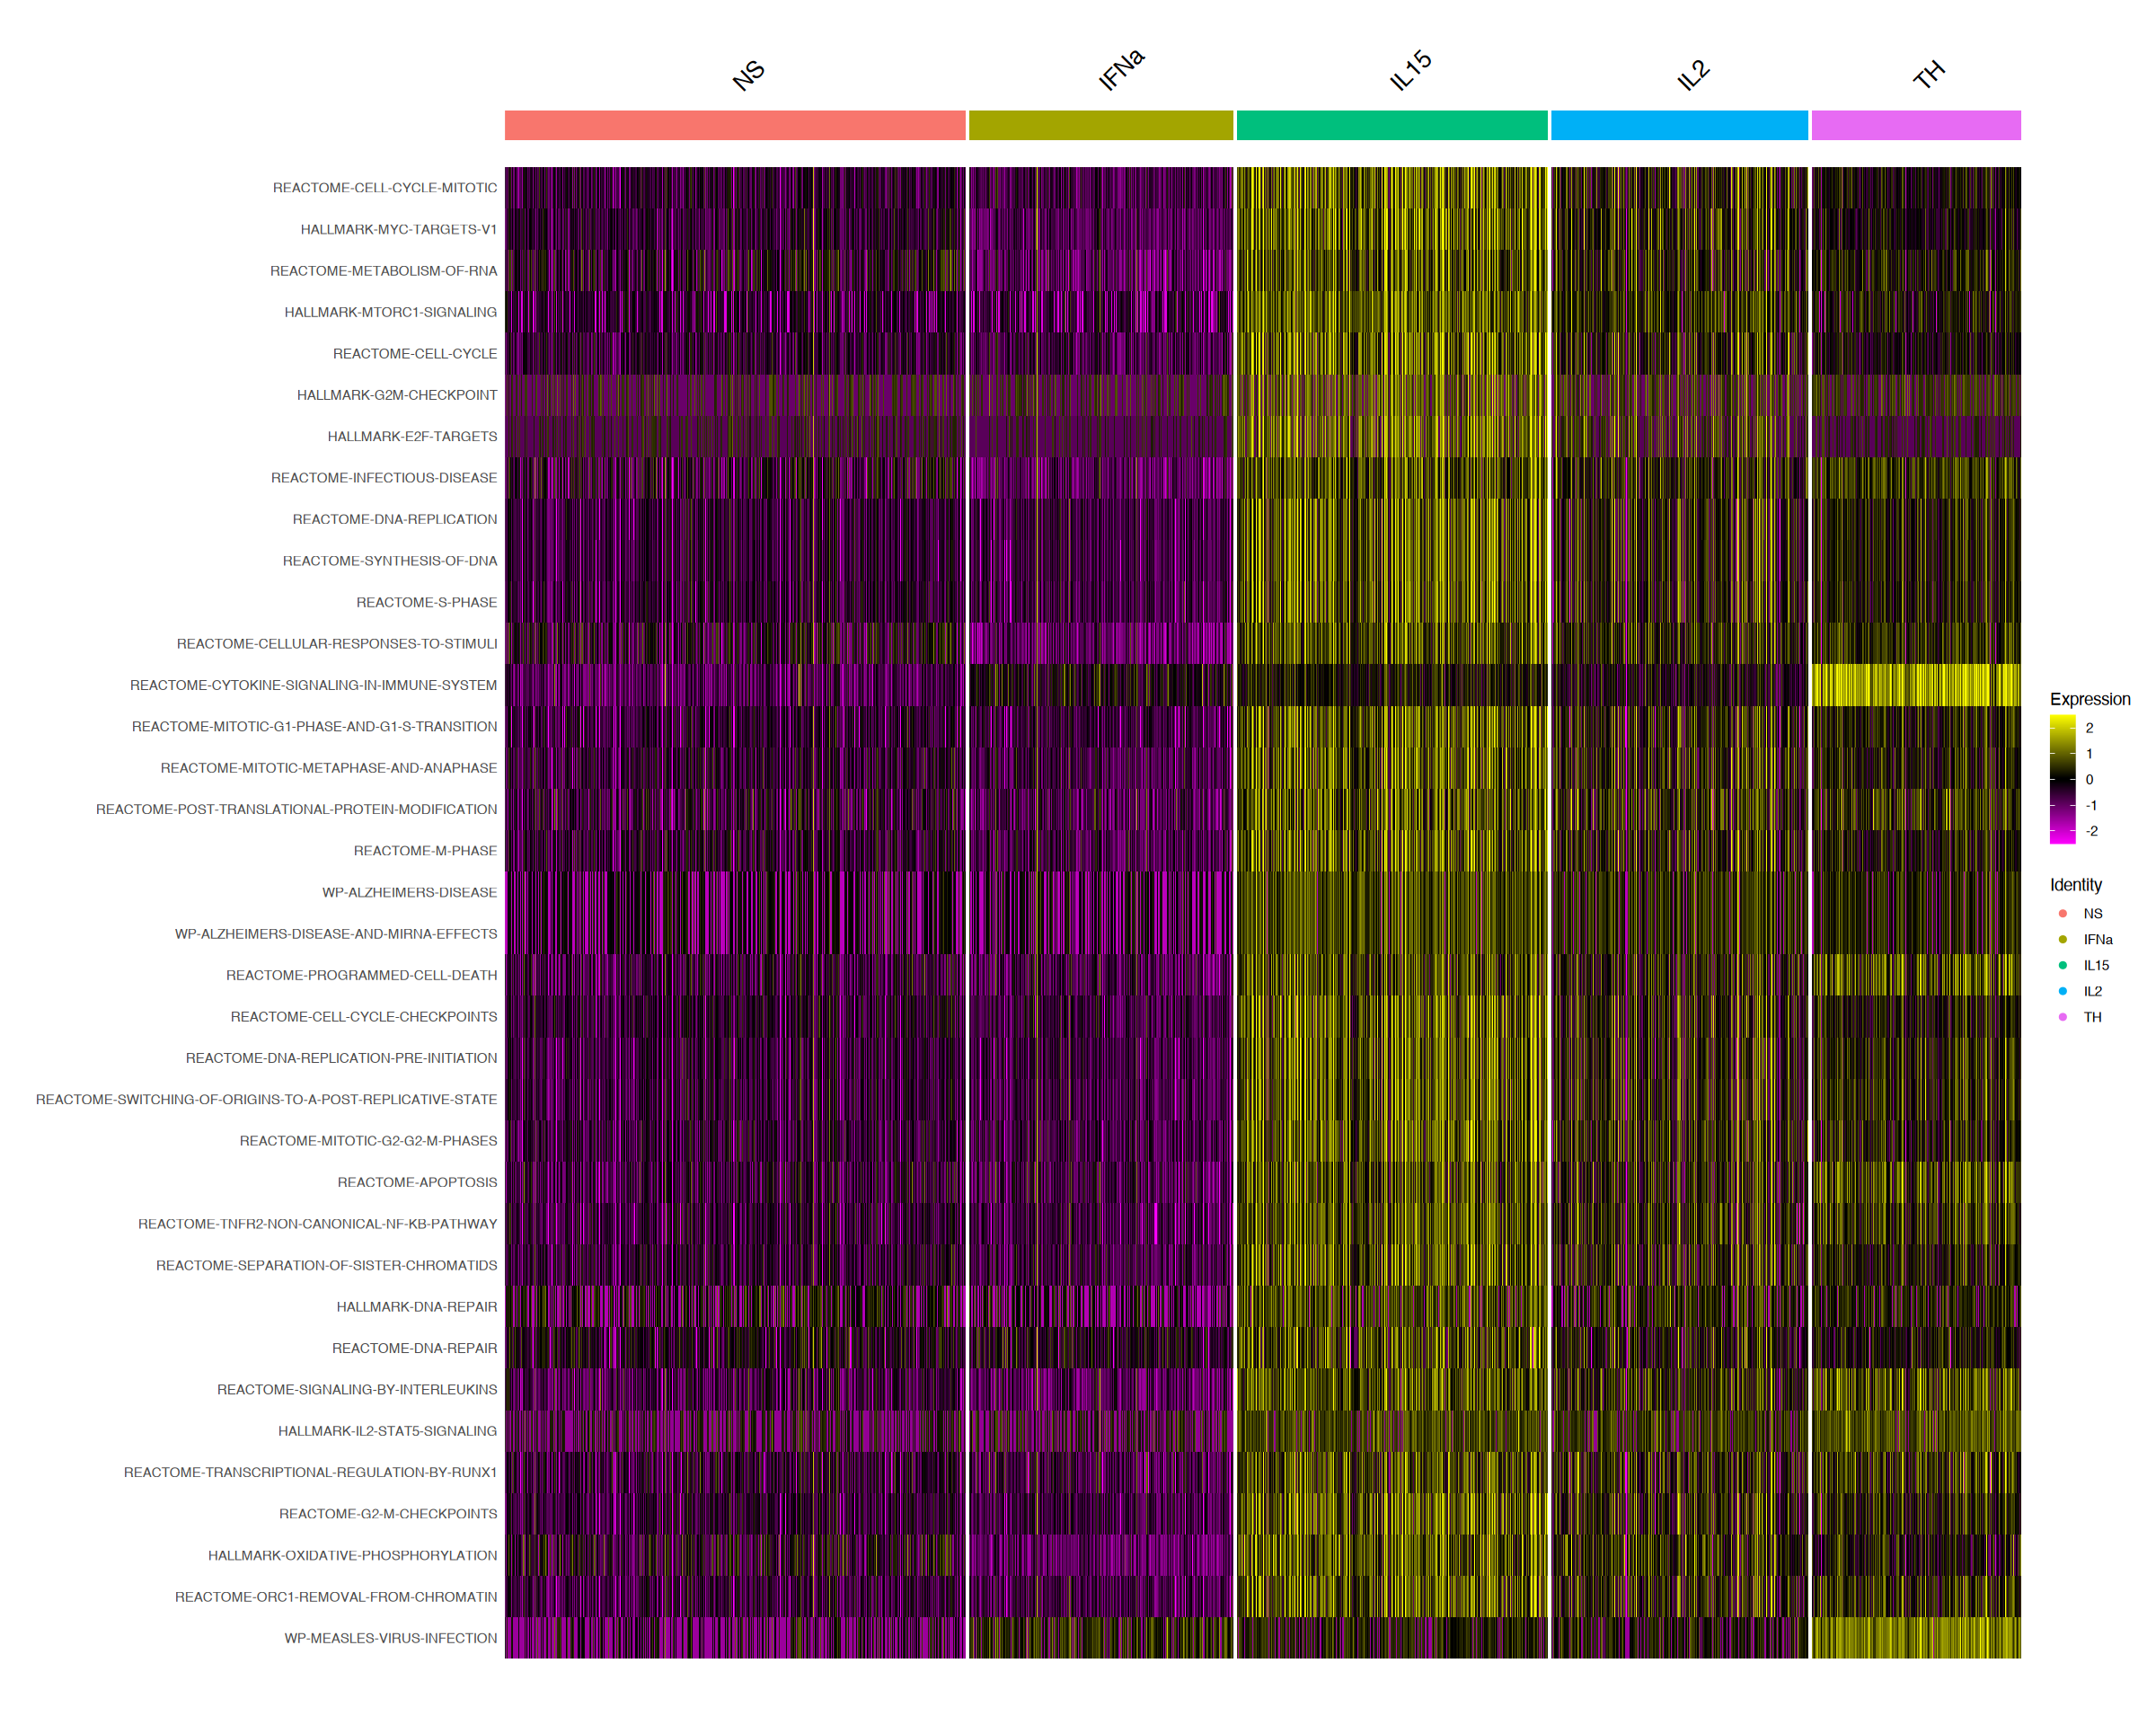

In [56]:
DefaultAssay(seurat_object) <- 'PAS'
seurat_object <- ScaleData(seurat_object)
Idents(seurat_object) <- seurat_object$Stim
options(repr.plot.width=20, repr.plot.height=16)

DoHeatmap(seurat_object,features=gsub("_","-",head(fgseaRes[order(fgseaRes$padj)],50)$pathway),slot="scale.data",assay="PAS",cells=sample(colnames(seurat_object),5000))


### Visualize PAS on UMAP and VlnPlot
Here we display the smoothed PAS of a few selected pathways on a UMAP and in a Violin plot.

Diplaying in a UMAP does allow us to see some subclustering of the pathways :
-  Only a subset of the IL15/IL2/TH ccells are expressing strongly the GLYCOLYSIS pathway
-  Only a subset of the IL15/IL2 cells are phasing.

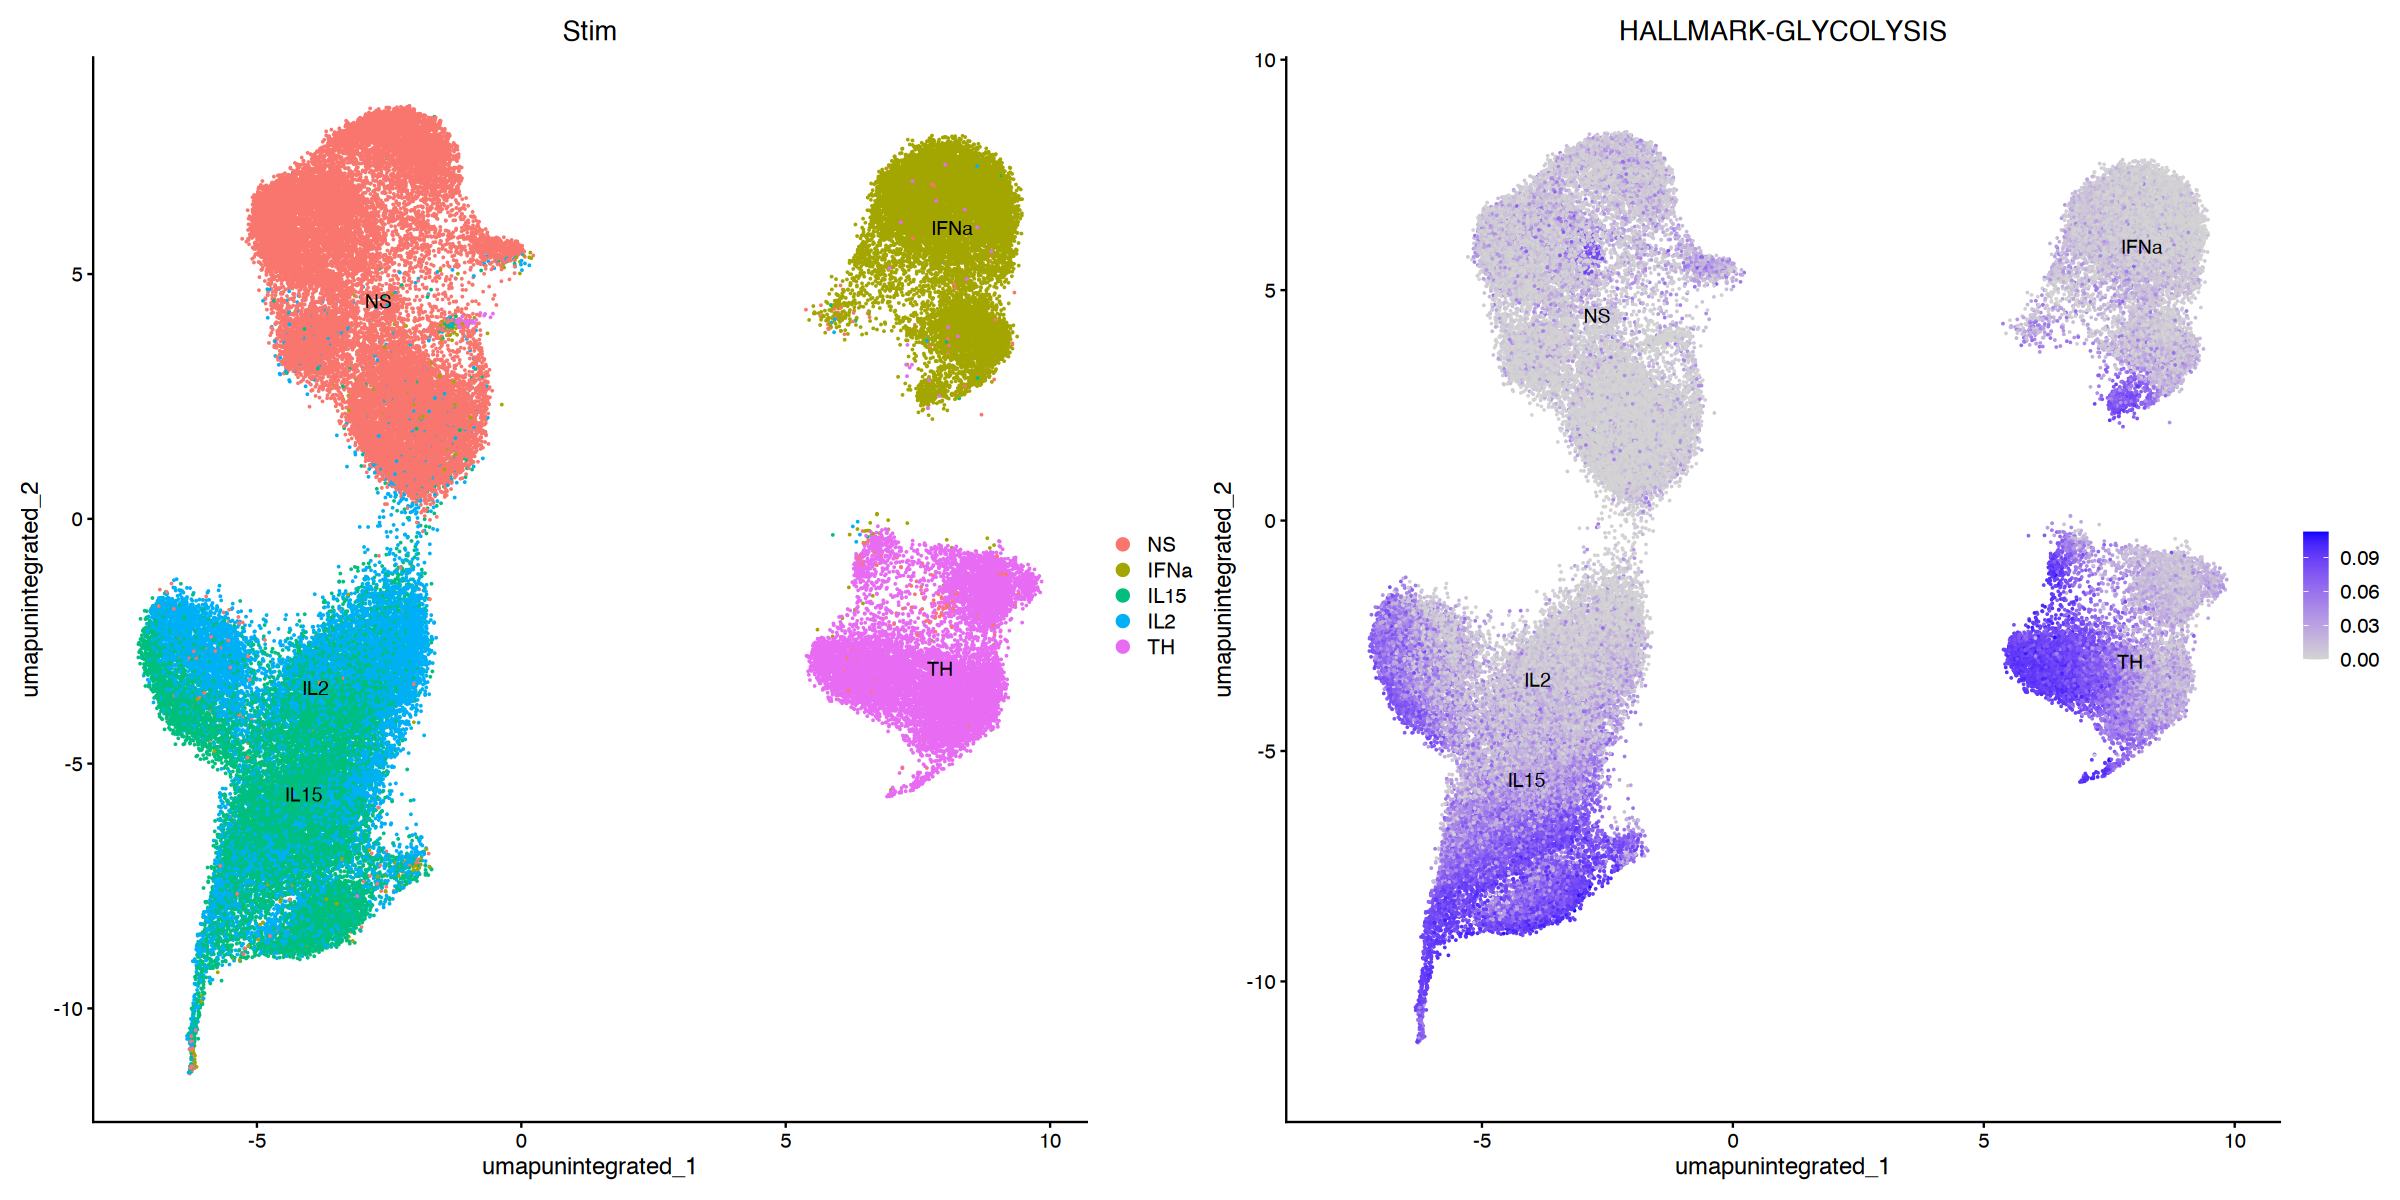

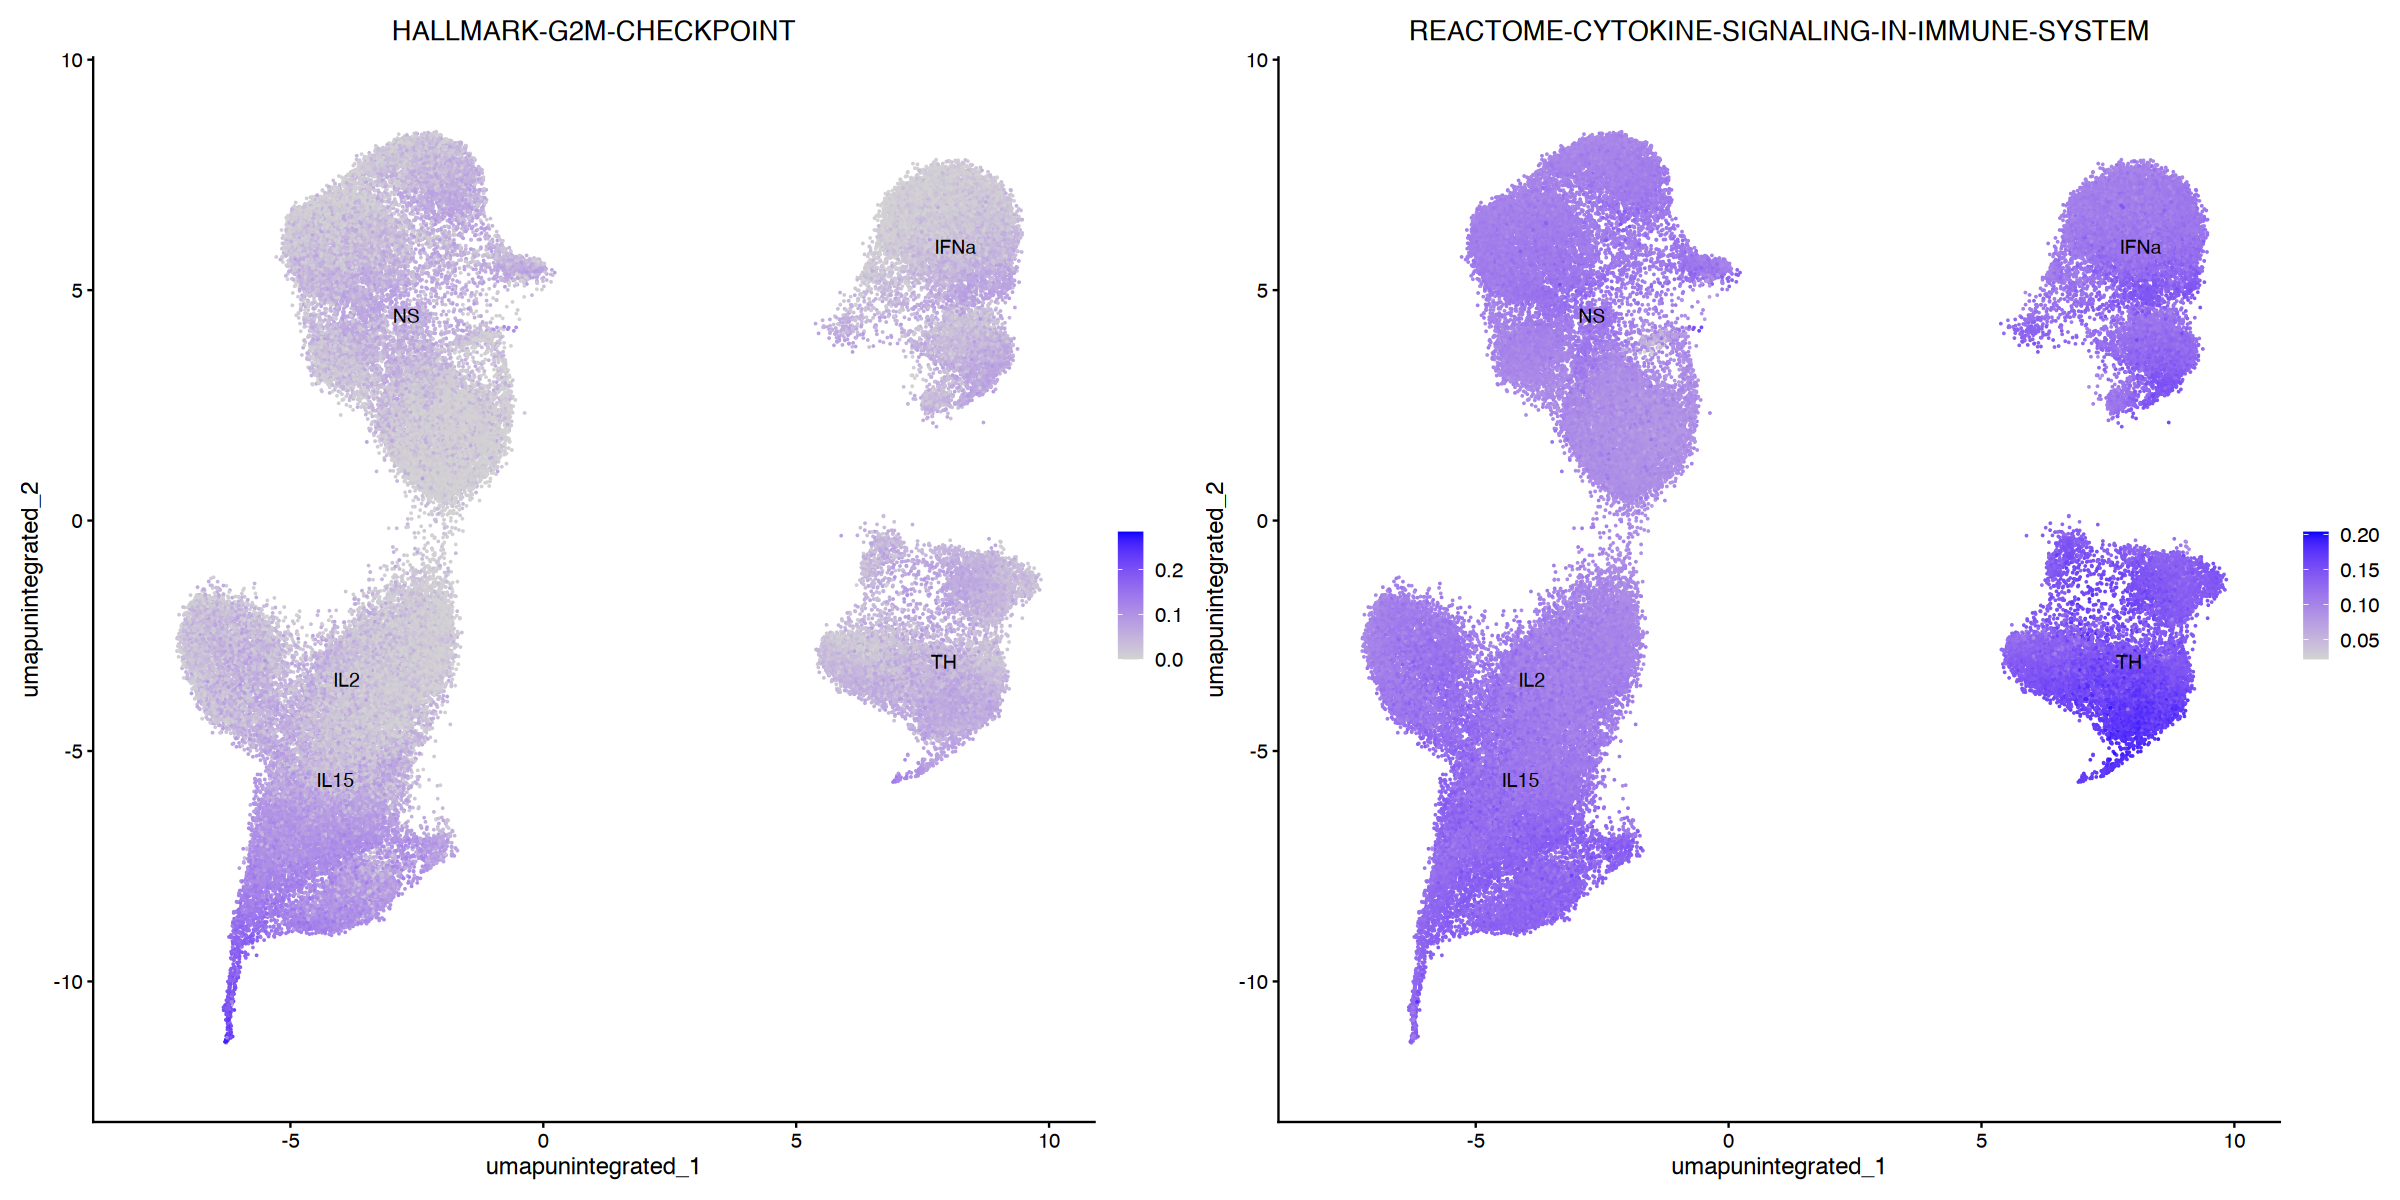

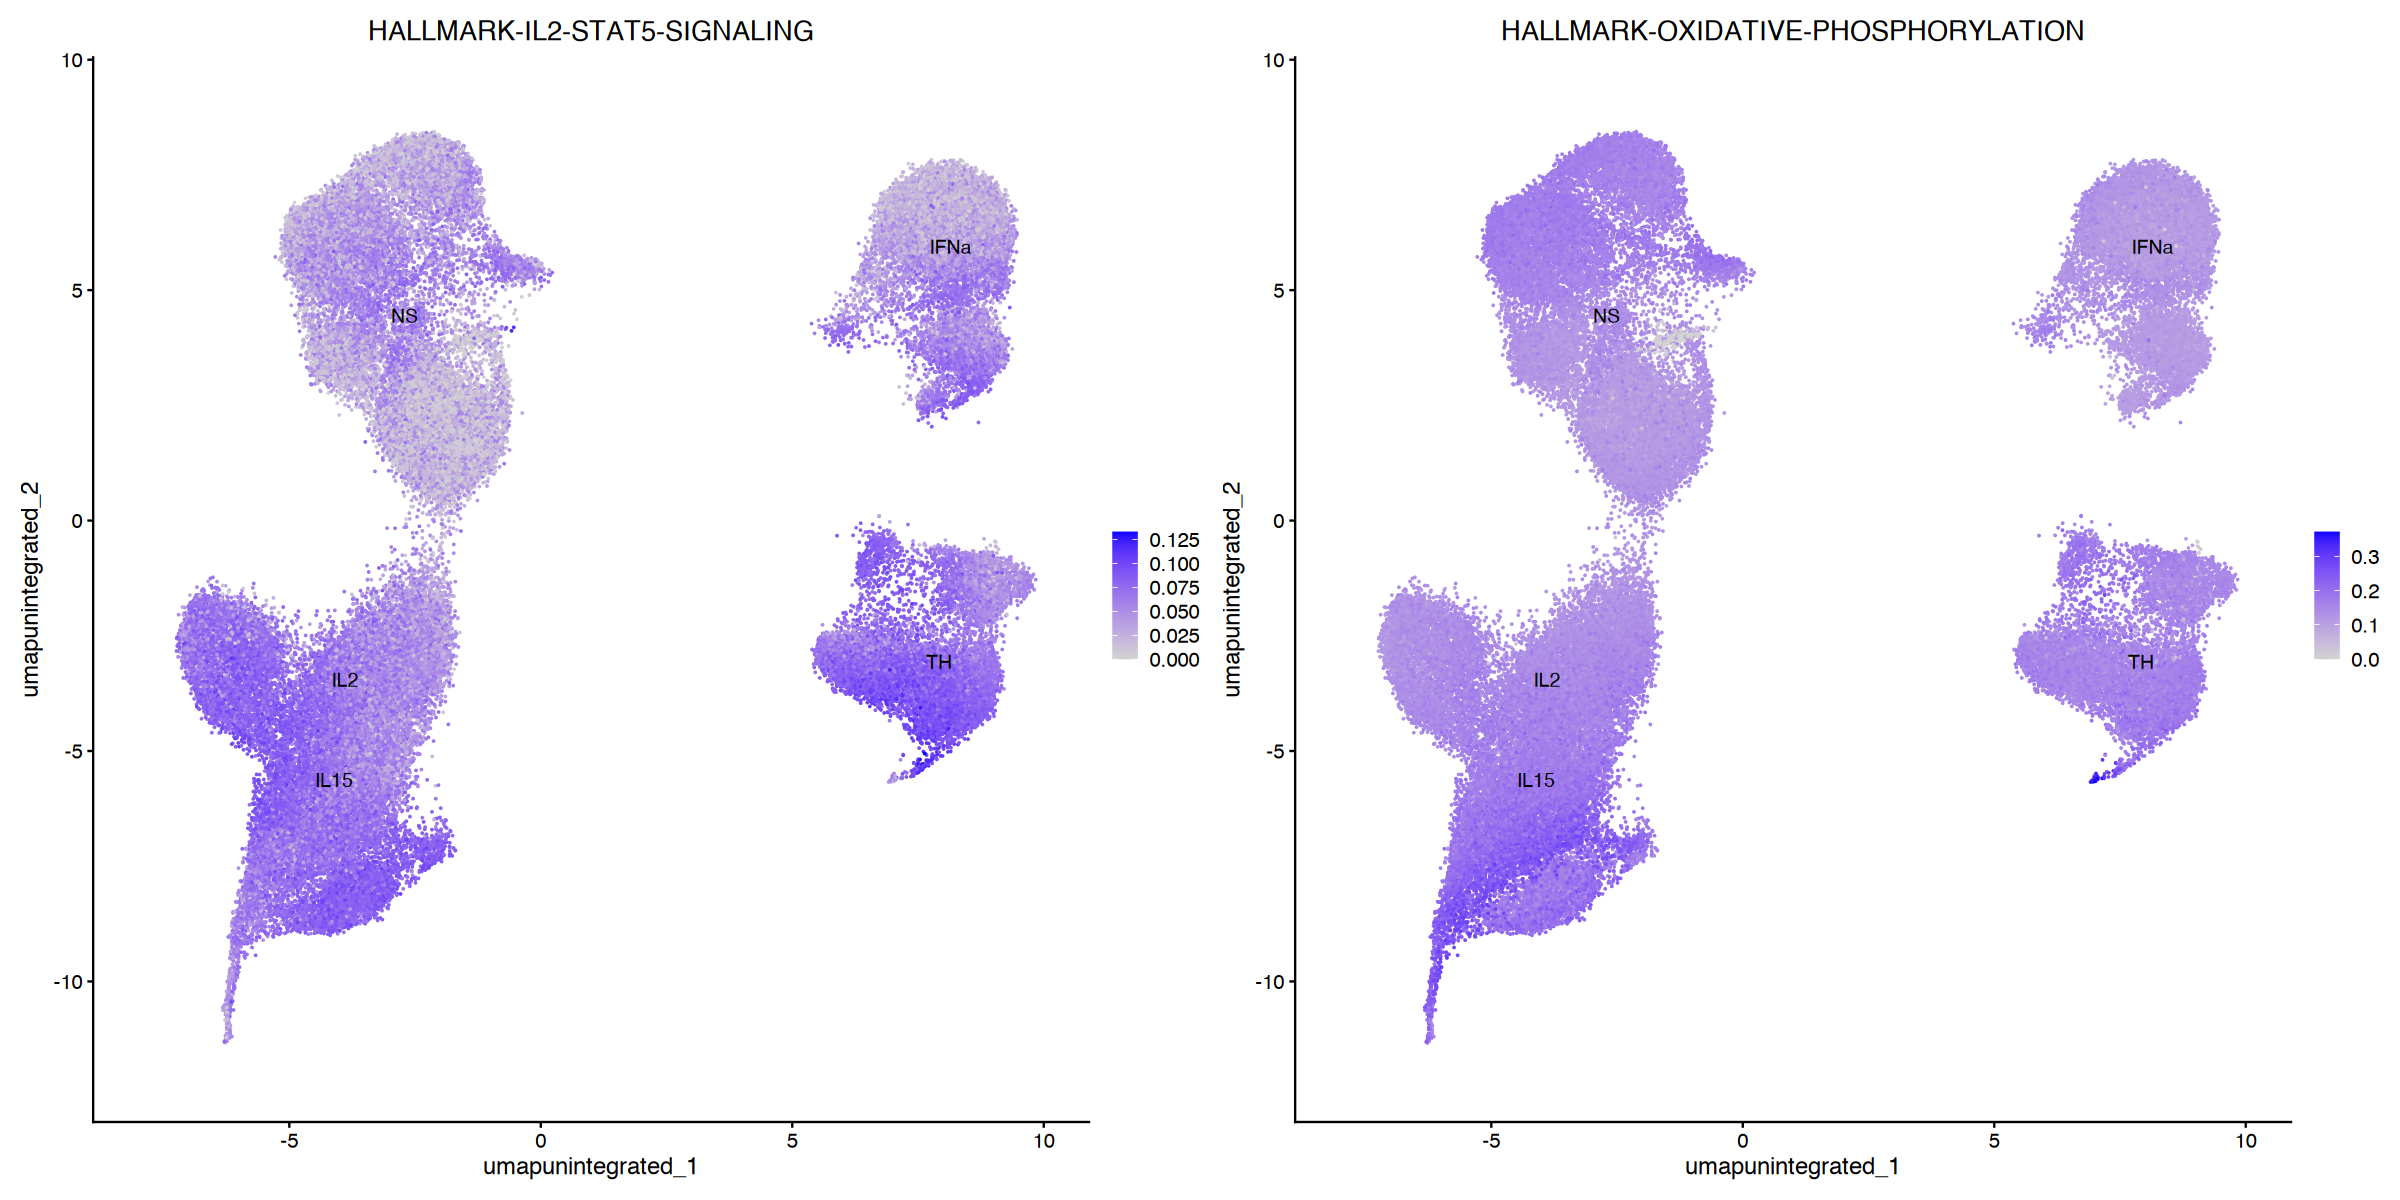

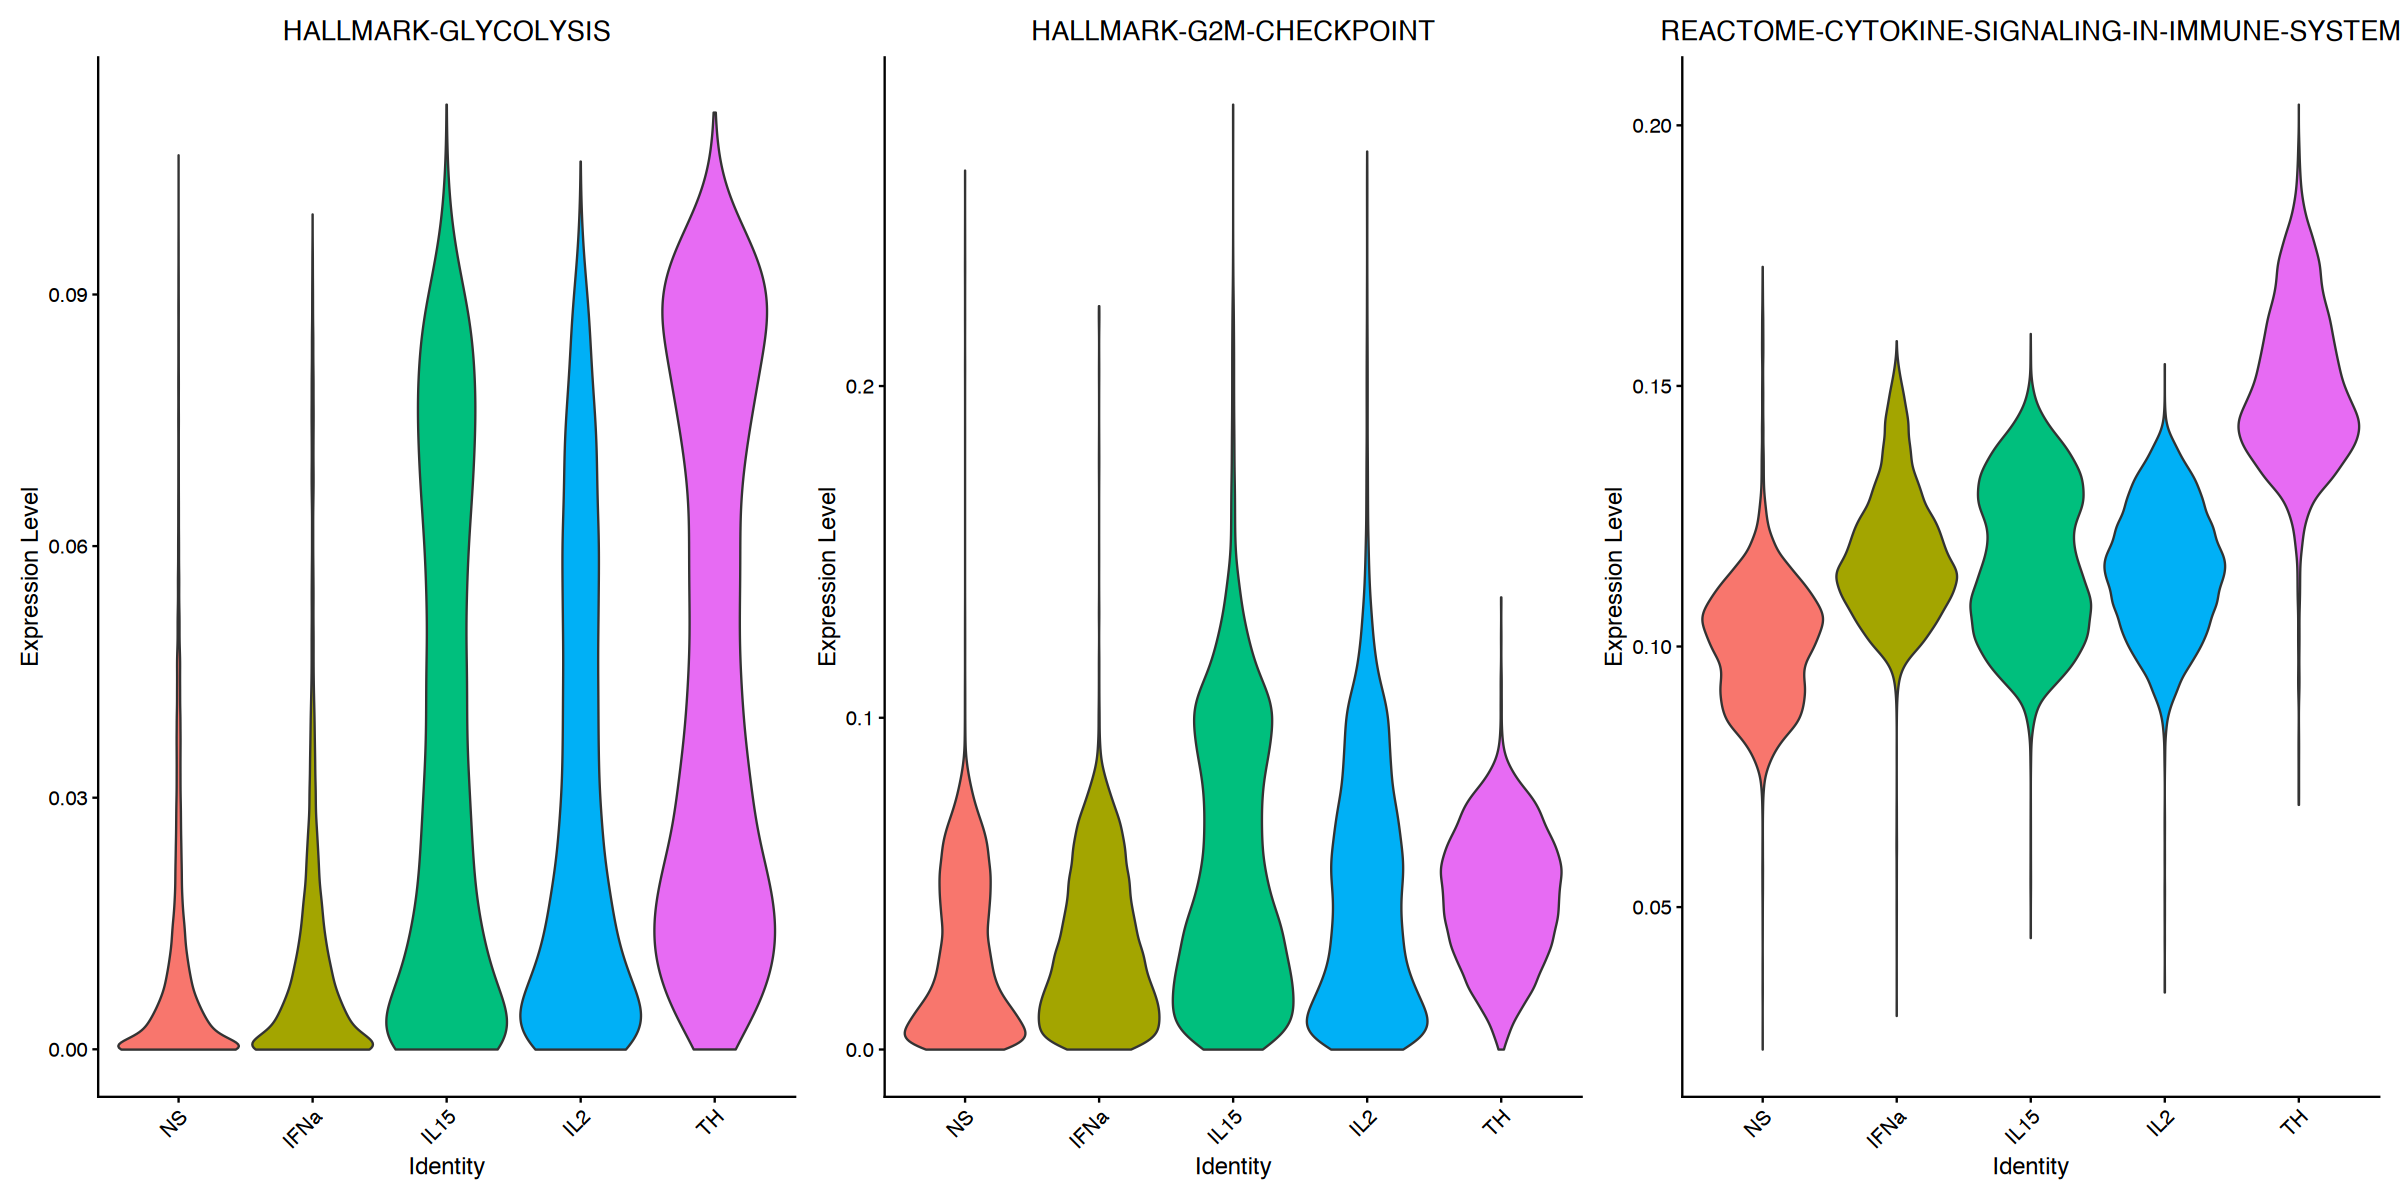

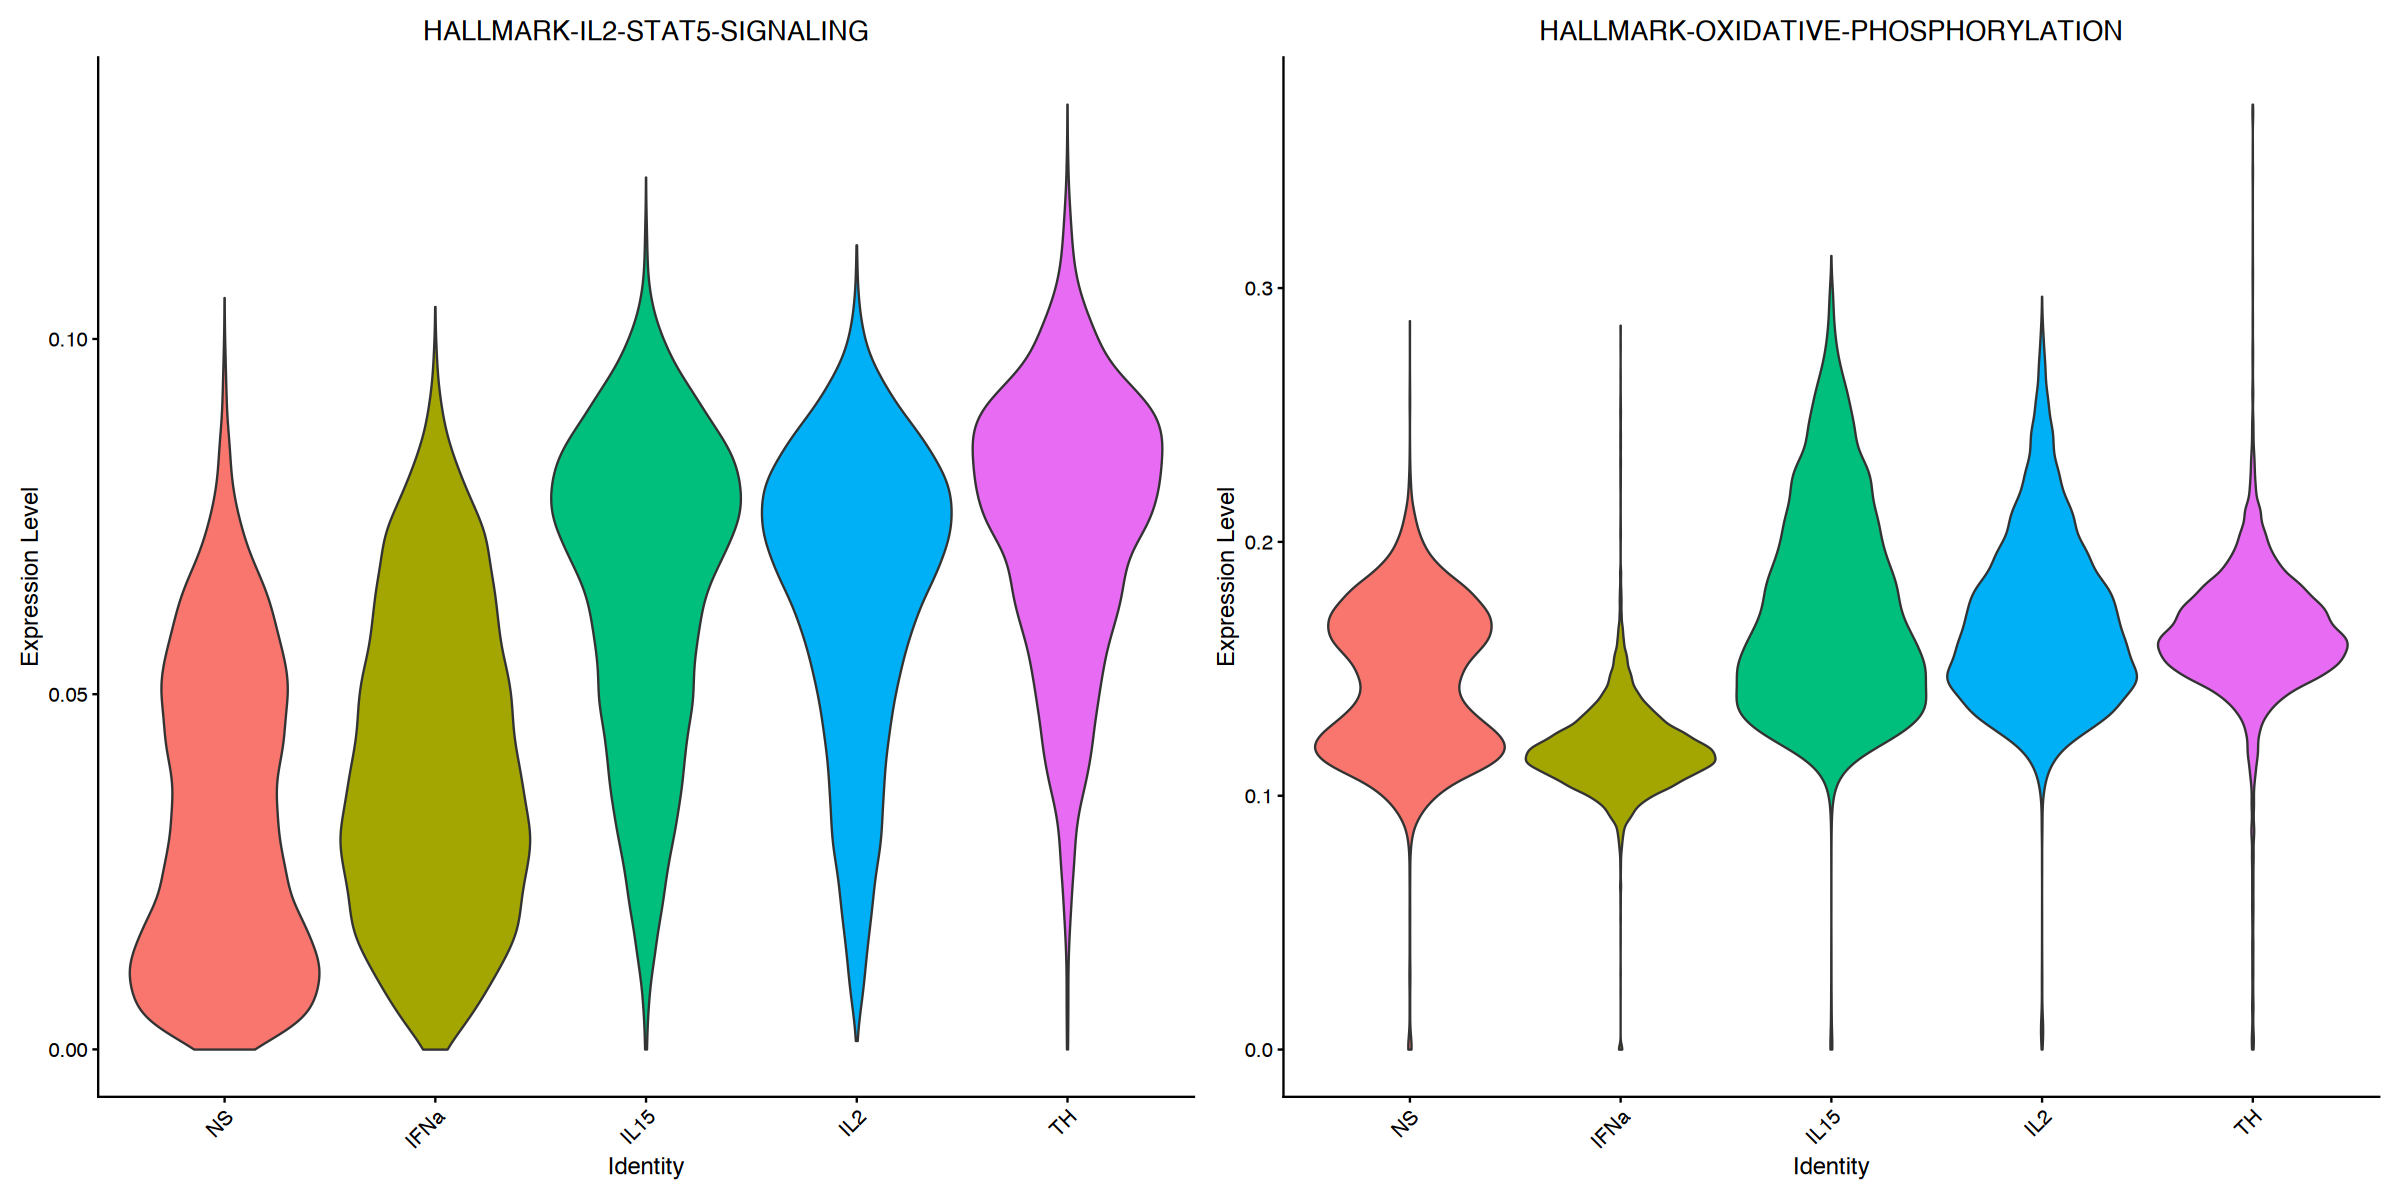

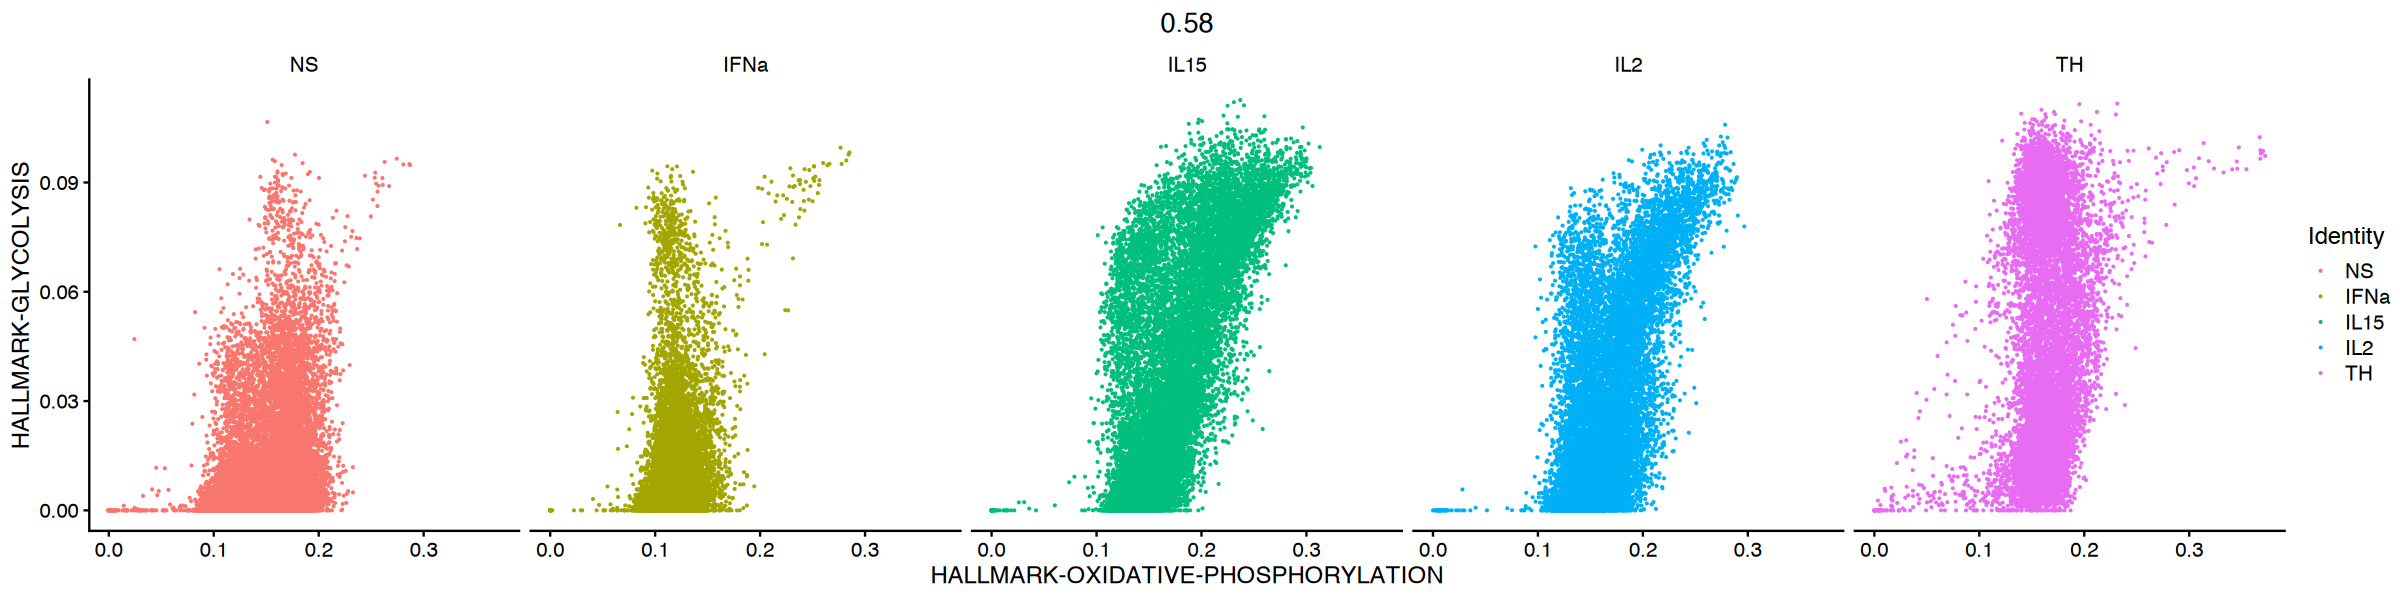

In [55]:

options(repr.plot.width=20, repr.plot.height=10)

DefaultAssay(seurat_object) <- 'PAS_Smooth'
DimPlot(seurat_object,group.by="Stim",label=TRUE) + FeaturePlot(seurat_object, features='HALLMARK-GLYCOLYSIS',label=TRUE,slot='data')
FeaturePlot(seurat_object, features=c('HALLMARK-G2M-CHECKPOINT','REACTOME-CYTOKINE-SIGNALING-IN-IMMUNE-SYSTEM'),label=TRUE,ncol=2,slot='data')
FeaturePlot(seurat_object, features=c('HALLMARK-IL2-STAT5-SIGNALING','HALLMARK-OXIDATIVE-PHOSPHORYLATION'),label=TRUE,ncol=2,slot='data')
VlnPlot(seurat_object,group.by="Stim",features=c('HALLMARK-GLYCOLYSIS','HALLMARK-G2M-CHECKPOINT','REACTOME-CYTOKINE-SIGNALING-IN-IMMUNE-SYSTEM'),pt.size=0)
VlnPlot(seurat_object,group.by="Stim",features=c('HALLMARK-IL2-STAT5-SIGNALING','HALLMARK-OXIDATIVE-PHOSPHORYLATION'),pt.size=0)
options(repr.plot.width=20, repr.plot.height=5)
FeatureScatter(seurat_object,group.by="Stim",split.by="Stim",feature2='HALLMARK-GLYCOLYSIS',feature1='HALLMARK-OXIDATIVE-PHOSPHORYLATION',pt.size=0.1)